In [4]:
from dsfunctions import forward_pass, forward_pass_nsteps, sample_windspeed, sample_winddirection, sample_geometry
from dsfunctions import plot_matrix, plot_matrix_ensemble, align_geoms, interpolate_geom, get_observation, plot_geometry

import numpy as np
from matplotlib import pyplot as plt

from shapely.geometry import Polygon

from tqdm import tqdm

## Generate observations

In [10]:
a = 1
b = 1.5
nphi = 20
n_vertex = nphi
phi = np.linspace(0,2*np.pi, nphi, endpoint=False)
nsteps = 100
step_size = 0.01

numberOfObservations = 10
observations = []
for i in range(numberOfObservations):
    x = (a*np.cos(phi))*(1.5**i)
    y = (b+i)*np.sin(phi)+i
    observations.append((x,y))

## Test Northward (180-deg wind)



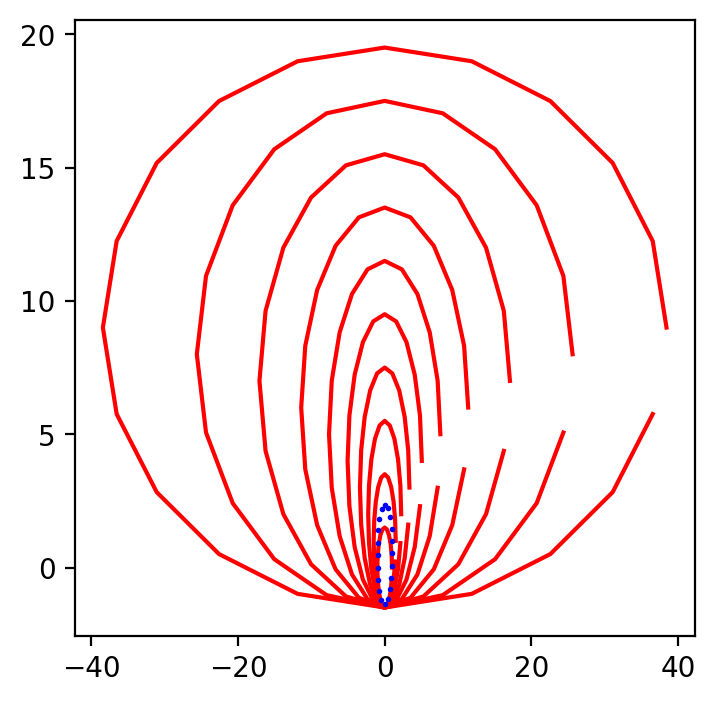

In [11]:
# wdlst = [90/180*np.pi]*200
wdlst = [90*np.pi/180]*100 + [90*np.pi/180]*100
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

x,y = observations[0]
xfin, yfin = forward_pass_nsteps(x, y, wdlst, step_size, nsteps)
for i in range(numberOfObservations):
    x,y = observations[i]
    ax.plot(x,y, 'r-')
ax.plot(xfin, yfin, 'b.', ms=2)

In [12]:
def align_states(state_lst, vertex_count=None):
    if vertex_count is None:
        vertex_count = len(state_lst[0])//2
    x0 = state_lst[0][::2]
    y0 = state_lst[0][1::2]
    x1 = state_lst[1][::2]
    y1 = state_lst[1][1::2]

    geom0 = Polygon(zip(x0,y0))
    geom1 = Polygon(zip(x1,y1))

    geom0, geom1 = align_geoms([geom0, geom1], vertex_count)
    x,y = geom0.exterior.coords.xy
    x0 = x.tolist()[:-1]
    y0 = y.tolist()[:-1]
    state0 = xy_to_state(x0, y0)
    
    x,y = geom1.exterior.coords.xy
    x1 = x.tolist()[:-1]
    y1 = y.tolist()[:-1]
    state1 = xy_to_state(x1, y1)

    return [state0, state1]
    
def xy_to_state(x, y):
    ret = []
    for i in range(len(x)):
        ret.append(x[i])
        ret.append(y[i])

    return np.array(ret).reshape((2*len(x),1))

def state_to_xy(state):
    return state[::2], state[1::2]

def sample_xy(x,y, rng):
    xs = rng.normal(x, scale=0.01)
    ys = rng.normal(y, scale=0.01)

    return xs,ys

## Calculated adjusted state

In [13]:
def adjusted_state_EnKF(initial_state, observation_state, 
                        X, n_states, n_samples, rng, 
                        sampled_wslst, sampled_wdlst,
                        step_size=0.01, nsteps=200):

    xkhat_ensemble = np.zeros((n_states, n_samples))
    wk_ensemble = np.zeros((n_states, n_samples))
    vk_ensemble = np.zeros((n_output, n_samples))
    
    zkphat_ensemble = np.zeros((n_states, n_samples))
    xkphat_ensemble = np.zeros((n_states, n_samples))
    ykhat_ensemble = np.zeros((n_output, n_samples))
    
    Xs = np.linalg.cholesky(X)
    # For each sample
    for s in tqdm(range(n_samples)):
    
        xkhat_ensemble[:,s:(s+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
    
        ws = sampled_wslst[s]
        wd = sampled_wdlst[s]
    
        x,y = state_to_xy(xkhat_ensemble[:, s:(s+1)])
        x1, y1 = forward_pass_nsteps(x, y, [wd]*nsteps, step_size*ws, nsteps)
        forward_state = xy_to_state(x1,y1)
        aligned_states = align_states([initial_state, forward_state])
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
        ykhat_ensemble[:,s:(s+1)] = xy_to_state(*sample_xy(observation_state[::2],observation_state[1::2],rng))
    
    zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
    ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)
    
    # Calculate errors
    # zkphat_ensemble -= zkphat_mean
    # ykhat_ensemble -= ykhat_mean
    ezkphat_ensemble = np.zeros_like(zkphat_ensemble)
    for n in range(n_states):
        ezkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]
    
    eykhat_ensemble = np.zeros_like(ykhat_ensemble)
    for n in range(n_output):
        eykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]
    
    Pzy = 1/n_samples*np.matmul(ezkphat_ensemble, eykhat_ensemble.T)
    
    Py = 1/n_samples*np.matmul(eykhat_ensemble, eykhat_ensemble.T)
    Pyinv = np.linalg.pinv(Py)
    assert(np.allclose(np.matmul(Py, Pyinv), np.eye(n_output))), 'Inverse calculation is incorrect'
    # warnings.warn('Not checking the inverse calculation')
    
    # Compute estimated Kalman gain based on correlations
    L_EnKF = np.matmul(Pzy, Pyinv)
    
    # compute mean valued state adjustment using measurement y(k)
    # yk = geom_to_state(observation['geometry'], n_states, nvertex)
    yk = observation_state
    adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)
    
    # Compute the state adjustment ensembles to update state covariance matrix X
    for j in range(n_samples):
        xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])
    
    # xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
    xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
    exkphat_ensemble = np.zeros_like(xkphat_ensemble)
    for n in range(n_states):
        exkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]
    
    X = 1/n_samples*np.matmul(exkphat_ensemble, exkphat_ensemble.T) + 1e-10*np.eye(n_states)
    
    return adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble


## Workflow for Data Assimilation

In [14]:
%%time

# Input of data assimilation
n_states = 2*n_vertex
n_output = n_states
n_samples = 100
wssigma = 1
wdsigma = 45
X = 100*np.eye(n_states)  # Initial covariance matrix
rng = np.random.Generator(np.random.PCG64(1234))

sampled_wslst = []
sampled_wdlst = []
for s in range(n_samples):
    sampled_wslst.append(sample_windspeed(1,wssigma,rng))
    sampled_wdlst.append(sample_winddirection(90, wdsigma, rng)/180*np.pi)



# adjusted_simulations
all_adjusted_states_lst = []
all_simulated_states_lst = []

# Prediction for tix=1
# Using the first observation, simulate to the next timepoint
initial_state = xy_to_state(*observations[0])
print('Setting up the first timepoint (ignition)')
all_adjusted_states_lst.append(initial_state)
all_simulated_states_lst.append(initial_state)
# For each sample of the wd and ws, run a simulation and take average as the final

print('Calculating the first prediction tix=1')
zkphat_ensemble = np.zeros((n_states, n_samples))
for s in tqdm(range(n_samples)):
    wd = sampled_wdlst[s]
    ws = sampled_wslst[s]
    
    x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
    forward_state = xy_to_state(x1,y1)
    aligned_states = align_states([initial_state, forward_state])
    
    zkphat_ensemble[:,s:(s+1)] = aligned_states[1]

zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
all_adjusted_states_lst.append(zkphat_mean)
all_simulated_states_lst.append(zkphat_mean)

print('Starting calculating of data assimilation')
### EnKF adjustments ###
Xlst = [X]

for tix in range(1,len(observations)):
    print(f'Calculating {tix}/{len(observations)}')
    # Using the forward simulation ensemble average as the initial_state for the next timepoint
    # Note that, we are now at tix=1, and predict for tix=2
    initial_state = all_adjusted_states_lst[-1]
    observation_state = xy_to_state(*observations[tix])
    
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble = adjusted_state_EnKF(initial_state, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst)
    Xlst.append(X)
    all_adjusted_states_lst.append(adjusted_state)

    initial_state = all_simulated_states_lst[-1]
    ## Calculating without any adjustments
    zkphat_ensemble = np.zeros((n_states, n_samples))
    for s in tqdm(range(n_samples)):
        wd = sampled_wdlst[s]
        ws = sampled_wslst[s]
        
        x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
        forward_state = xy_to_state(x1,y1)
        aligned_states = align_states([initial_state, forward_state])
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
    all_simulated_states_lst.append(zkphat_ensemble.mean(axis=1, keepdims=True))

Setting up the first timepoint (ignition)
Calculating the first prediction tix=1


100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


Starting calculating of data assimilation
Calculating 1/10


100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


Calculating 2/10


100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


Calculating 3/10


100%|██████████| 100/100 [00:07<00:00, 13.96it/s]


Calculating 4/10


100%|██████████| 100/100 [00:07<00:00, 14.07it/s]


Calculating 5/10


100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


Calculating 6/10


100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


Calculating 7/10


100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


Calculating 8/10


100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


Calculating 9/10


100%|██████████| 100/100 [00:07<00:00, 13.87it/s]

CPU times: user 3min 20s, sys: 1 s, total: 3min 21s
Wall time: 3min 20s


## Plot observations and calculations

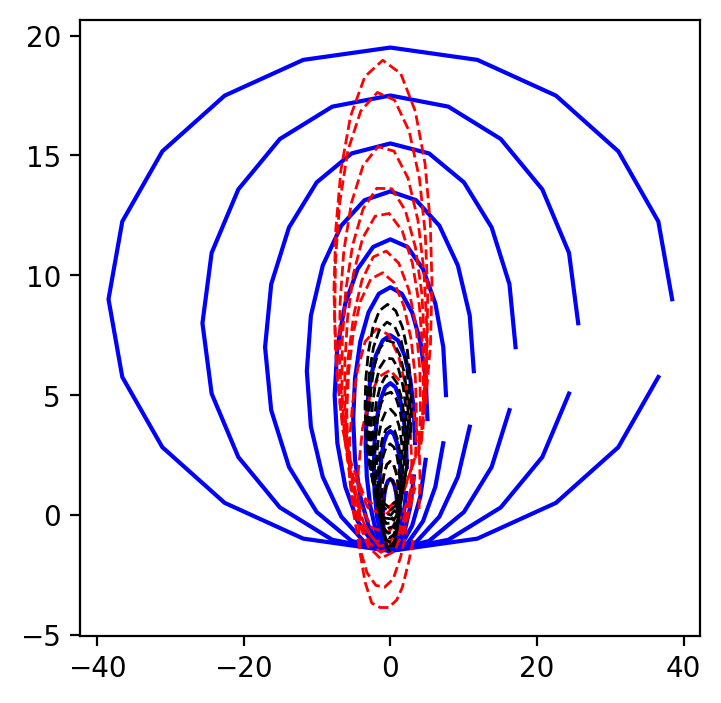

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for observation in observations:
    ax.plot(*observation, color=(0,0,1))

for state in all_adjusted_states_lst:
    ax.plot(state[::2], state[1::2], color=(1,0,0), lw=1, ls='--')

for state in all_simulated_states_lst:
    ax.plot(state[::2], state[1::2], color=(0,0,0), lw=1, ls='--')
    
# ax.set_aspect('equal')

## Interpolated observations

In [40]:
# Interpolate between observations
ndivide = 10

observations_interp = [observations[0]]
for oix in range(1,len(observations)):
    x0,y0 = observations[oix-1]
    x1,y1 = observations[oix]

    xlst_observation = np.linspace(x0, x1, 10, endpoint=False)
    ylst_observation = np.linspace(y0, y1, 10, endpoint=False)

    for x,y in zip(xlst_observation, ylst_observation):
        observations_interp.append((x,y))    

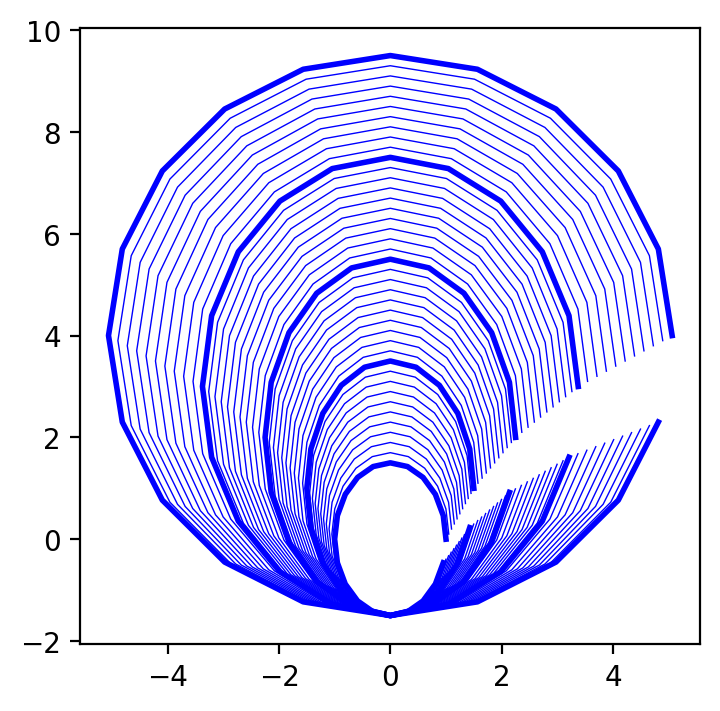

In [41]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for observation in observations:
    ax.plot(*observation, color=(0,0,1), lw=2)

for observation in observations_interp:
    ax.plot(*observation, color=(0,0,1), lw=0.5)

In [42]:
%%time

# Input of data assimilation
n_states = 2*n_vertex
n_output = n_states
n_samples = 100
wssigma = 1
wdsigma = 45
X = 100*np.eye(n_states)  # Initial covariance matrix
rng = np.random.Generator(np.random.PCG64(1234))

sampled_wslst = []
sampled_wdlst = []
for s in range(n_samples):
    sampled_wslst.append(sample_windspeed(1,wssigma,rng))
    sampled_wdlst.append(sample_winddirection(90, wdsigma, rng)/180*np.pi)


# adjusted_simulations
all_adjusted_states_lst = []
all_simulated_states_lst = []

# Default values
step_size = 0.01
nsteps = 200//ndivide

# Prediction for tix=1
# Using the first observation, simulate to the next timepoint
initial_state = xy_to_state(*observations_interp[0])
print('Setting up the first timepoint (ignition)')
all_adjusted_states_lst.append(initial_state)
all_simulated_states_lst.append(initial_state)
# For each sample of the wd and ws, run a simulation and take average as the final

print('Calculating the first prediction tix=1')
zkphat_ensemble = np.zeros((n_states, n_samples))
for s in tqdm(range(n_samples)):
    wd = sampled_wdlst[s]
    ws = sampled_wslst[s]
    
    x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
    forward_state = xy_to_state(x1,y1)
    aligned_states = align_states([initial_state, forward_state])
    
    zkphat_ensemble[:,s:(s+1)] = aligned_states[1]

zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
all_adjusted_states_lst.append(zkphat_mean)
all_simulated_states_lst.append(zkphat_mean)

print('Starting calculating of data assimilation')
### EnKF adjustments ###
Xlst = [X]

for tix in range(1,len(observations_interp)):
    print(f'Calculating {tix}/{len(observations_interp)}')
    # Using the forward simulation ensemble average as the initial_state for the next timepoint
    # Note that, we are now at tix=1, and predict for tix=2
    initial_state = all_adjusted_states_lst[-1]
    observation_state = xy_to_state(*observations_interp[tix])
    
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble = adjusted_state_EnKF(initial_state, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst, nsteps=nsteps)
    Xlst.append(X)
    all_adjusted_states_lst.append(adjusted_state)

    initial_state = all_simulated_states_lst[-1]
    ## Calculating without any adjustments
    zkphat_ensemble = np.zeros((n_states, n_samples))
    for s in tqdm(range(n_samples)):
        wd = sampled_wdlst[s]
        ws = sampled_wslst[s]
        
        x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
        forward_state = xy_to_state(x1,y1)
        aligned_states = align_states([initial_state, forward_state])
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
    all_simulated_states_lst.append(zkphat_ensemble.mean(axis=1, keepdims=True))

Setting up the first timepoint (ignition)
Calculating the first prediction tix=1


100%|██████████| 100/100 [00:01<00:00, 51.73it/s]


Starting calculating of data assimilation
Calculating 1/41


100%|██████████| 100/100 [00:01<00:00, 51.00it/s]


Calculating 2/41


100%|██████████| 100/100 [00:01<00:00, 51.47it/s]


Calculating 3/41


100%|██████████| 100/100 [00:01<00:00, 51.36it/s]


Calculating 4/41


100%|██████████| 100/100 [00:01<00:00, 51.68it/s]


Calculating 5/41


100%|██████████| 100/100 [00:01<00:00, 51.60it/s]


Calculating 6/41


100%|██████████| 100/100 [00:01<00:00, 51.96it/s]


Calculating 7/41


100%|██████████| 100/100 [00:01<00:00, 51.28it/s]


Calculating 8/41


100%|██████████| 100/100 [00:01<00:00, 51.26it/s]


Calculating 9/41


100%|██████████| 100/100 [00:01<00:00, 51.81it/s]


Calculating 10/41


100%|██████████| 100/100 [00:01<00:00, 51.68it/s]


Calculating 11/41


100%|██████████| 100/100 [00:01<00:00, 51.95it/s]


Calculating 12/41


100%|██████████| 100/100 [00:01<00:00, 51.99it/s]


Calculating 13/41


100%|██████████| 100/100 [00:01<00:00, 51.20it/s]


Calculating 14/41


100%|██████████| 100/100 [00:01<00:00, 50.29it/s]


Calculating 15/41


100%|██████████| 100/100 [00:01<00:00, 50.46it/s]


Calculating 16/41


100%|██████████| 100/100 [00:01<00:00, 50.62it/s]


Calculating 17/41


100%|██████████| 100/100 [00:01<00:00, 50.90it/s]


Calculating 18/41


100%|██████████| 100/100 [00:01<00:00, 50.91it/s]


Calculating 19/41


100%|██████████| 100/100 [00:01<00:00, 50.96it/s]


Calculating 20/41


100%|██████████| 100/100 [00:01<00:00, 50.84it/s]


Calculating 21/41


100%|██████████| 100/100 [00:01<00:00, 51.05it/s]


Calculating 22/41


100%|██████████| 100/100 [00:01<00:00, 51.15it/s]


Calculating 23/41


100%|██████████| 100/100 [00:01<00:00, 50.93it/s]


Calculating 24/41


100%|██████████| 100/100 [00:01<00:00, 51.03it/s]


Calculating 25/41


100%|██████████| 100/100 [00:01<00:00, 50.96it/s]


Calculating 26/41


100%|██████████| 100/100 [00:01<00:00, 51.17it/s]


Calculating 27/41


100%|██████████| 100/100 [00:01<00:00, 50.87it/s]


Calculating 28/41


100%|██████████| 100/100 [00:01<00:00, 51.04it/s]


Calculating 29/41


100%|██████████| 100/100 [00:01<00:00, 51.19it/s]


Calculating 30/41


100%|██████████| 100/100 [00:01<00:00, 50.83it/s]


Calculating 31/41


100%|██████████| 100/100 [00:01<00:00, 50.85it/s]


Calculating 32/41


100%|██████████| 100/100 [00:01<00:00, 51.00it/s]


Calculating 33/41


100%|██████████| 100/100 [00:01<00:00, 51.10it/s]


Calculating 34/41


100%|██████████| 100/100 [00:01<00:00, 50.70it/s]


Calculating 35/41


100%|██████████| 100/100 [00:01<00:00, 50.35it/s]


Calculating 36/41


100%|██████████| 100/100 [00:01<00:00, 50.18it/s]


Calculating 37/41


100%|██████████| 100/100 [00:01<00:00, 50.07it/s]


Calculating 38/41


100%|██████████| 100/100 [00:02<00:00, 49.97it/s]


Calculating 39/41


100%|██████████| 100/100 [00:01<00:00, 50.33it/s]


Calculating 40/41


100%|██████████| 100/100 [00:01<00:00, 50.58it/s]

CPU times: user 2min 39s, sys: 3.97 s, total: 2min 43s
Wall time: 2min 39s


### Plot observations/adjusted calculations

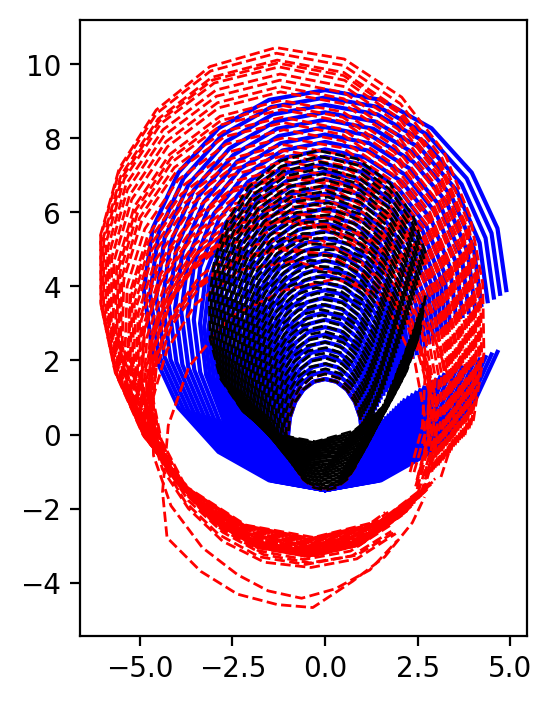

In [47]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for observation in observations_interp:
    ax.plot(*observation, color=(0,0,1))

for state in all_adjusted_states_lst:
    ax.plot(state[::2], state[1::2], color=(1,0,0), lw=1, ls='--')

for state in all_simulated_states_lst:
    ax.plot(state[::2], state[1::2], color=(0,0,0), lw=1, ls='--')
    
ax.set_aspect('equal')

In [46]:
for X in Xlst:
    print(X.trace())

4000.0
794.5088067369467
334.1609580660336
190.95184084619984
88.50905235521833
52.83470699593569
34.80116322591904
22.148310652189693
15.004632720752326
8.862908223871376
5.229282585348827
3.613855389480614
2.1283141008092534
1.669401221391964
1.3301768584048923
1.2133630944694
1.1537497479534335
1.1387637052387352
0.9576909176683628
0.9593918157796208
0.9070341918749536
0.9534788153295295
0.9335274930126122
0.9515912498825783
0.795556926810278
0.8178064430823706
0.6908774146817405
0.668107925375687
0.8411737051961288
0.7619030977443577
0.7623499541196934
0.8869805685417295
1.1198371530277367
0.9758400307565224
0.85877839753099
0.8634693662975716
0.7899934432662268
0.7290547095086262
0.7474217866919628
0.8141440956408083
0.8901035738712673


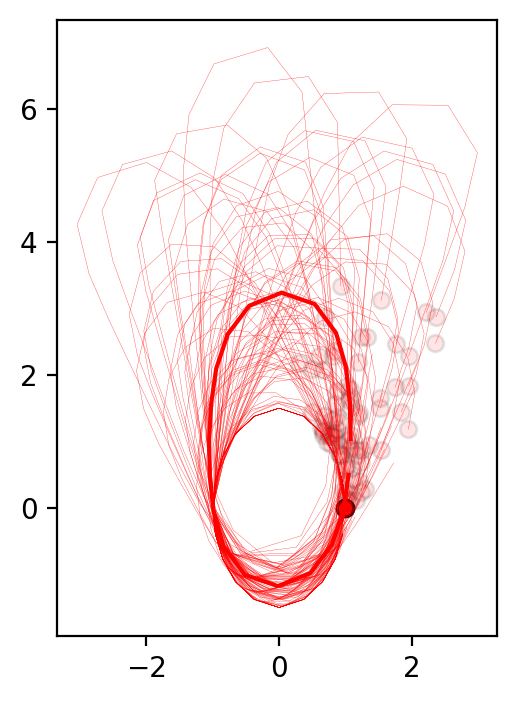

In [108]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix_ensemble(zkphat_ensemble, ax=ax, color=(1,0,0), lw=0.1, plot_alix=0)
plot_matrix(zkphat_ensemble, ax=ax, color=(1,0,0))
ax.set_aspect('equal')

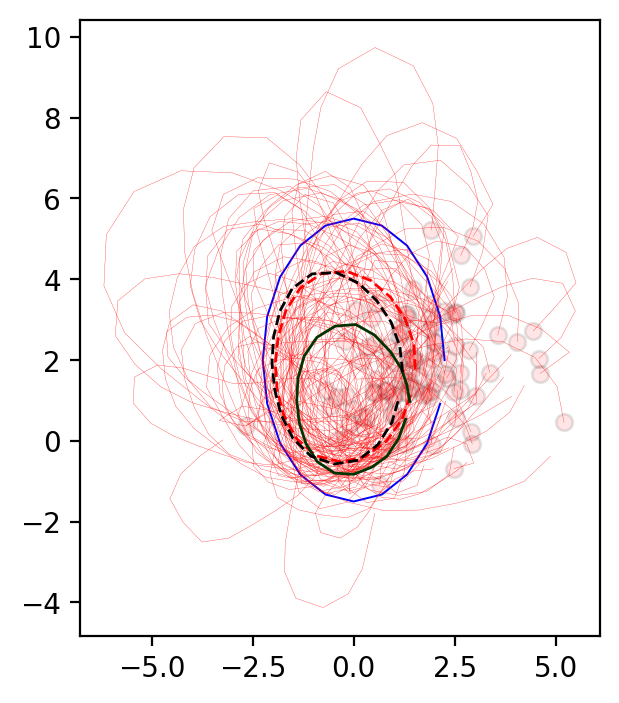

In [75]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)



# ax.plot(*observations[2], 'b-', lw=0.4)

# ax.plot(*observations[1], 'b-', lw=1)
# plot_matrix_ensemble(zkphat_ensemble, ax=ax, color=(1,0,0), lw=0.1, plot_alix=0)
# plot_matrix(zkphat_ensemble, ax=ax, color=(1,0,0), lw=1, ls='--')
# plot_matrix_ensemble(ykhat_ensemble, ax=ax, color=(0,0,1), lw=0.1, plot_alix=0)
# ax.plot(adjusted_state[::2], adjusted_state[1::2], color=(0,0,0), lw=1, ls='--')


ax.plot(*observations[2], 'b-', lw=0.7)
plot_matrix_ensemble(zkphat_ensemble2, ax=ax, color=(1,0,0), lw=0.1, plot_alix=0)
plot_matrix(zkphat_ensemble2, ax=ax, color=(1,0,0), lw=1, ls='--')
ax.plot(adjusted_state[::2], adjusted_state[1::2], color=(0,0.2,0), lw=1)
ax.plot(adjusted_state2[::2], adjusted_state2[1::2], color=(0,0,0), lw=1, ls='--')
# plot_matrix_ensemble(ykhat_ensemble2, ax=ax, color=(0,0,1), lw=0.1, plot_alix=0)


# ax.plot(*observations[3], 'b-', lw=0.5)
# plot_matrix_ensemble(zkphat_ensemble3, ax=ax, color=(1,0,0), lw=0.1, plot_alix=0)
# plot_matrix(zkphat_ensemble3, ax=ax, color=(1,0,0), lw=1, ls='--')
# ax.plot(adjusted_state2[::2], adjusted_state2[1::2], color=(0,0.2,0), lw=1)
# ax.plot(adjusted_state3[::2], adjusted_state3[1::2], color=(0,0,0), lw=1, ls='--')
# plot_matrix_ensemble(ykhat_ensemble3, ax=ax, color=(0,0,1), lw=0.1, plot_alix=0)




ax.set_aspect('equal')

In [76]:
for X in Xlst:
    print(X.trace())

40.0
33.98348508132339
39.99234717339638
51.574230623416135


## Adjusted state with interpolation between observations

In [348]:
x0,y0 = observations[0]
initial_state = xy_to_state(x0,y0)
observation_state = initial_state.copy()
n_states = 2*n_vertex
n_output = n_states
n_samples = 100
wssigma = 0.05
wdsigma = 1
step_size = 0.01
nsteps = 200
X = 0.001*np.eye(n_states)

rng = np.random.Generator(np.random.PCG64(1234))

sampled_wslst = []
sampled_wdlst = []
for s in range(n_samples):
    sampled_wslst.append(sample_windspeed(1,wssigma,rng))
    sampled_wdlst.append(sample_winddirection(90, wdsigma, rng))

# Interpolate between observations
x0,y0 = observations[0]
x1,y1 = observations[1]

xlst_observation = np.linspace(x0, x1, 10, endpoint=False)
ylst_observation = np.linspace(y0, y1, 10, endpoint=False)
adjusted_state_lst = []
for i in range(len(xlst)):
    print(f'{i}/{len(xlst)}')
    x = xlst_observation[i]
    y = ylst_observation[i]
    if i == 0:
        initial_state = xy_to_state(x,y)
    else:
        initial_state = adjusted_state

    observation_state = xy_to_state(x,y)
    adjusted_state, X = adjusted_state_EnKF(initial_state, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst, nsteps=nsteps//len(xlst))

    adjusted_state_lst.append(adjusted_state)


    
# Interpolate between observations
x2,y2 = observations[2]

xlst_observation = np.linspace(x1, x2, 10, endpoint=False)
ylst_observation = np.linspace(y1, y2, 10, endpoint=False)
adjusted_state_lst = []
for i in range(len(xlst)):
    print(f'{i}/{len(xlst)}')
    x = xlst_observation[i]
    y = ylst_observation[i]
    if i == 0:
        initial_state = xy_to_state(x,y)
    else:
        initial_state = adjusted_state2

    observation_state = xy_to_state(x,y)
    adjusted_state2, X = adjusted_state_EnKF(initial_state, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst, nsteps=nsteps//len(xlst))

    adjusted_state_lst.append(adjusted_state2)

    
    
    
    # observation_state = xy_to_state(*observations[1])
# adjusted_state2, X = adjusted_state_EnKF(adjusted_state, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst)

# observation_state = xy_to_state(*observations[2])
# adjusted_state3, X = adjusted_state_EnKF(adjusted_state2, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst)

0/10


100%|██████████| 100/100 [00:01<00:00, 75.41it/s]


1/10


100%|██████████| 100/100 [00:01<00:00, 75.61it/s]


2/10


100%|██████████| 100/100 [00:01<00:00, 75.52it/s]


3/10


100%|██████████| 100/100 [00:01<00:00, 75.20it/s]


4/10


100%|██████████| 100/100 [00:01<00:00, 75.15it/s]


5/10


100%|██████████| 100/100 [00:01<00:00, 75.17it/s]


6/10


100%|██████████| 100/100 [00:01<00:00, 74.97it/s]


7/10


100%|██████████| 100/100 [00:01<00:00, 75.37it/s]


8/10


100%|██████████| 100/100 [00:01<00:00, 75.38it/s]


9/10


100%|██████████| 100/100 [00:01<00:00, 75.71it/s]


0/10


100%|██████████| 100/100 [00:01<00:00, 75.12it/s]


1/10


100%|██████████| 100/100 [00:01<00:00, 73.87it/s]


2/10


100%|██████████| 100/100 [00:01<00:00, 74.73it/s]


3/10


100%|██████████| 100/100 [00:01<00:00, 74.47it/s]


4/10


100%|██████████| 100/100 [00:01<00:00, 75.39it/s]


5/10


100%|██████████| 100/100 [00:01<00:00, 75.18it/s]


6/10


100%|██████████| 100/100 [00:01<00:00, 75.12it/s]


7/10


100%|██████████| 100/100 [00:01<00:00, 75.05it/s]


8/10


100%|██████████| 100/100 [00:01<00:00, 74.17it/s]


9/10


100%|██████████| 100/100 [00:01<00:00, 74.44it/s]


## Maria Fire

In [12]:
maria_observations = []
maria_timestamps = []
for tix in range(5):
    obs, ts = get_observation('Maria2019', tix)
    maria_observations.append(obs)
    maria_timestamps.append(ts)

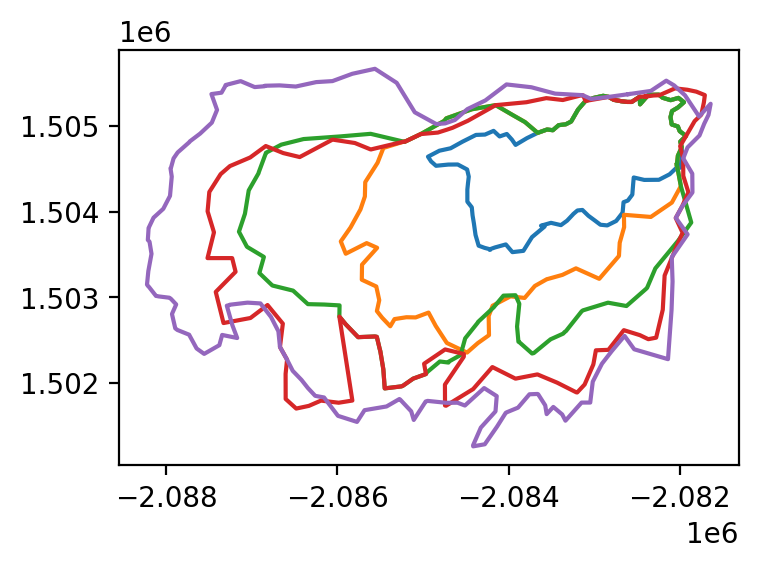

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for obs in maria_observations:
    plot_geometry(obs, ax=ax)